In [35]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

In [2]:
flood_hazard_map_5yr = gpd.read_file('noah_data/5yr/MetroManila5yr.zip', crs='EPSG:32633')
flood_hazard_map_25yr = gpd.read_file('noah_data/25yr/MetroManila25yr.zip', crs='EPSG:32633')
flood_hazard_map_100yr = gpd.read_file('noah_data/100yr/MetroManila100yr.zip', crs='EPSG:32633')

### Reading 5yr Hazard Map data

In [3]:
flood_hazard_map_5yr.head()

,Var,geometry
0,1.0,"MULTIPOLYGON (((121.00712 14.35398, 121.00703 ..."
1,2.0,"MULTIPOLYGON (((121.00703 14.35398, 121.00703 ..."
2,3.0,"MULTIPOLYGON (((121.00694 14.35398, 121.00694 ..."


In [3]:
# verify Point lies within the hazard map
flood_hazard_map_5yr.to_crs(epsg=4326).geometry.contains(Point(121.00712, 14.35398))

0     True
1    False
2    False
dtype: bool

In [30]:
flood_hazard_map_5yr.crs

<Projected CRS: EPSG:32651>
Name: WGS 84 / UTM zone 51N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°E and 126°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Indonesia. Japan. North Korea. Philippines. Russian Federation. South Korea. Taiwan.
- bounds: (120.0, 0.0, 126.0, 84.0)
Coordinate Operation:
- name: UTM zone 51N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
# let's convert to lon lat instead of easting and northing
flood_hazard_map_5yr_wgs84 = flood_hazard_map_5yr.to_crs(epsg=4326)

In [53]:
flood_hazard_map_5yr_wgs84.head()

,Var,geometry
0,1.0,"MULTIPOLYGON (((121.01127 14.37505, 121.01127 ..."
1,2.0,"MULTIPOLYGON (((121.01163 14.37578, 121.01163 ..."
2,3.0,"MULTIPOLYGON (((121.02891 14.37732, 121.02900 ..."


,Var,geometry
0,1.0,"MULTIPOLYGON (((121.01127 14.37505, 121.01127 ..."
1,2.0,"MULTIPOLYGON (((121.01163 14.37578, 121.01163 ..."
2,3.0,"MULTIPOLYGON (((121.02891 14.37732, 121.02900 ..."


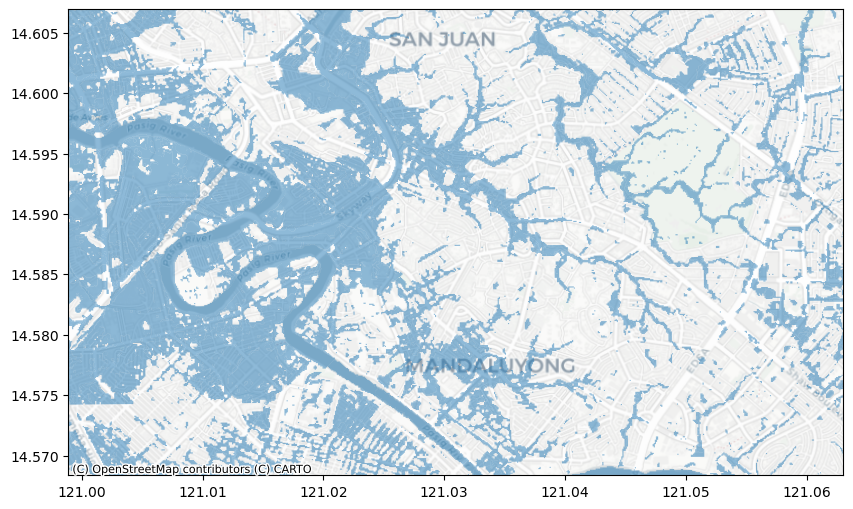

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
flood_hazard_map_5yr_wgs84.plot(ax=ax, alpha=0.5)
ax.set_xlim([120.99891, 121.06303])  # Set x-axis (longitude) limits
ax.set_ylim([14.56838, 14.60692])  # Set y-axis (latitude) limits
ax.set_axis_off()
cx.add_basemap(ax=ax, crs=flood_hazard_map_5yr_wgs84.crs, source=cx.providers.CartoDB.Positron);

In [13]:
fig.savefig('plots/T307_5yr.png', bbox_inches='tight');

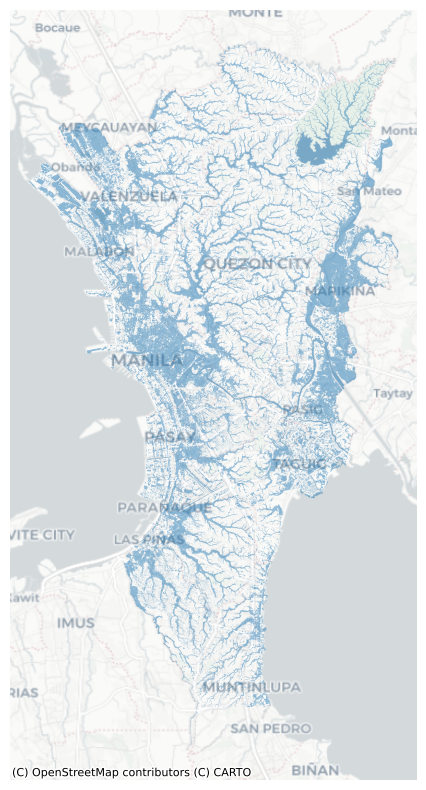

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
flood_hazard_map_5yr_wgs84.plot(ax=ax, alpha=0.5)
ax.set_axis_off()
cx.add_basemap(ax=ax, crs=flood_hazard_map_5yr_wgs84.crs, source=cx.providers.CartoDB.Positron);

Now, let's perform a spatial join of the flood hazard map with our flood landscape data. 

In [5]:
flood_data = pd.read_csv('aegis_flood_data/AEGISDataset.csv')

In [10]:
flood_data.head()

,lat,lon,flood_heig,elevation,precipitat
0,14.640394,121.055708,0,54.553295,9.0
1,14.698299,121.002132,0,21.856272,10.0
2,14.698858,121.100261,0,69.322807,16.0
3,14.571310,120.983334,0,10.987241,8.0
4,14.762232,121.075735,0,87.889847,18.0


In [6]:
# rename columns
flood_data = flood_data.rename(columns={"flood_heig": "flood_height", "precipitat": "precipitation"})

In [7]:
# reclassify data
flood_data['is_flooding'] = flood_data['flood_height'].apply(lambda x: 0 if x <= 1 else 1)

In [8]:
flood_hazard_map_25yr_wgs84 = flood_hazard_map_25yr.to_crs(epsg=4326)
flood_hazard_map_100yr_wgs84 = flood_hazard_map_100yr.to_crs(epsg=4326)

In [9]:
def turn_df_into_gdf(dataframe):
    # Create a GeoDataFrame from the DataFrame by setting geometry from the lat and lon columns
    return gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe.lon, dataframe.lat), crs='EPSG:4326')

flood_data_gdf = turn_df_into_gdf(flood_data)

In [22]:
flood_data_gdf.head()

,lat,lon,flood_height,elevation,precipitation,is_flooding,geometry
0,14.640394,121.055708,0,54.553295,9.0,0,POINT (121.05571 14.64039)
1,14.698299,121.002132,0,21.856272,10.0,0,POINT (121.00213 14.69830)
2,14.698858,121.100261,0,69.322807,16.0,0,POINT (121.10026 14.69886)
3,14.571310,120.983334,0,10.987241,8.0,0,POINT (120.98333 14.57131)
4,14.762232,121.075735,0,87.889847,18.0,0,POINT (121.07573 14.76223)


In [10]:
flood_hazard_map_5yr_wgs84.head()

,Var,geometry
0,1.0,"MULTIPOLYGON (((121.00712 14.35398, 121.00703 ..."
1,2.0,"MULTIPOLYGON (((121.00703 14.35398, 121.00703 ..."
2,3.0,"MULTIPOLYGON (((121.00694 14.35398, 121.00694 ..."


In [11]:
# spatial join of flood data with flood hazard map using left join
flood_data_gdf_5y = gpd.sjoin(flood_data_gdf, flood_hazard_map_5yr_wgs84, how='left', predicate='within')
flood_data_gdf_25yr = gpd.sjoin(flood_data_gdf, flood_hazard_map_25yr_wgs84, how='left', predicate='within')
flood_data_gdf_100yr = gpd.sjoin(flood_data_gdf, flood_hazard_map_100yr_wgs84, how='left', predicate='within')

In [12]:
# save the previous dataframes to csv
flood_data_gdf_5y.to_csv('aegis_flood_data/AEGISDataset_SJOIN5yr.csv')
flood_data_gdf_25yr.to_csv('aegis_flood_data/AEGISDataset_SJOIN25yr.csv')
flood_data_gdf_100yr.to_csv('aegis_flood_data/AEGISDataset_SJOIN100yr.csv')

In [14]:
flood_data_gdf.head()

,lat,lon,flood_height,elevation,precipitation,is_flooding,geometry
0,14.640394,121.055708,0,54.553295,9.0,0,POINT (121.05571 14.64039)
1,14.698299,121.002132,0,21.856272,10.0,0,POINT (121.00213 14.69830)
2,14.698858,121.100261,0,69.322807,16.0,0,POINT (121.10026 14.69886)
3,14.571310,120.983334,0,10.987241,8.0,0,POINT (120.98333 14.57131)
4,14.762232,121.075735,0,87.889847,18.0,0,POINT (121.07573 14.76223)


In [13]:
flood_data_gdf_5y.head()

,lat,lon,flood_height,elevation,precipitation,is_flooding,geometry,index_right,Var
0,14.640394,121.055708,0,54.553295,9.0,0,POINT (121.05571 14.64039),NaN,NaN
1,14.698299,121.002132,0,21.856272,10.0,0,POINT (121.00213 14.69830),NaN,NaN
2,14.698858,121.100261,0,69.322807,16.0,0,POINT (121.10026 14.69886),NaN,NaN
3,14.571310,120.983334,0,10.987241,8.0,0,POINT (120.98333 14.57131),NaN,NaN
4,14.762232,121.075735,0,87.889847,18.0,0,POINT (121.07573 14.76223),NaN,NaN


They have the same indices, so we can merge them into a single dataframe.

In [15]:
flood_data_gdf_5y = flood_data_gdf_5y.rename(columns={"index_right": "index_right_5yr"})
flood_data_gdf_25yr = flood_data_gdf_25yr.rename(columns={"index_right": "index_right_25yr"})
flood_data_gdf_100yr = flood_data_gdf_100yr.rename(columns={"index_right": "index_right_100yr"})

In [18]:
# since we're joining on the index, we can drop everything except the index_right column
flood_data_gdf_5y = flood_data_gdf_5y[['index_right_5yr']]
flood_data_gdf_25yr = flood_data_gdf_25yr[['index_right_25yr']]
flood_data_gdf_100yr = flood_data_gdf_100yr[['index_right_100yr']]

In [27]:
flood_data_merged = flood_data_gdf.merge(flood_data_gdf_5y, how='left', left_index=True, right_index=True)
flood_data_merged = flood_data_merged.merge(flood_data_gdf_25yr, how='left', left_index=True, right_index=True)
flood_data_merged = flood_data_merged.merge(flood_data_gdf_100yr, how='left', left_index=True, right_index=True)

In [28]:
flood_data_merged.head()

,lat,lon,flood_height,elevation,precipitation,is_flooding,geometry,index_right_5yr,index_right_25yr,index_right_100yr
0,14.640394,121.055708,0,54.553295,9.0,0,POINT (121.05571 14.64039),NaN,NaN,NaN
1,14.698299,121.002132,0,21.856272,10.0,0,POINT (121.00213 14.69830),NaN,NaN,NaN
2,14.698858,121.100261,0,69.322807,16.0,0,POINT (121.10026 14.69886),NaN,NaN,NaN
3,14.571310,120.983334,0,10.987241,8.0,0,POINT (120.98333 14.57131),NaN,NaN,NaN
4,14.762232,121.075735,0,87.889847,18.0,0,POINT (121.07573 14.76223),NaN,NaN,NaN


In [29]:
len(flood_data_merged)

3511

In [30]:
flood_data_merged.to_csv('aegis_flood_data/AEGISDataset_SJOIN_merged.csv')

In [31]:
# create a new column to indicate the hazard level of a point
flood_data_merged['hazard_level'] = 0

In [52]:
def merge_hazard_levels(row):
    if pd.isna(row['index_right_5yr']) is False:
        return 0.25
    elif pd.isna(row['index_right_25yr']) is False:
        return 0.05
    elif pd.isna(row['index_right_100yr']) is False:
        return 0.01
    else:
        return 0

In [53]:
flood_data_merged['hazard_level'] = flood_data_merged.apply(merge_hazard_levels, axis=1)

In [55]:
flood_data_merged.head()

,lat,lon,flood_height,elevation,precipitation,is_flooding,geometry,index_right_5yr,index_right_25yr,index_right_100yr,hazard_level
0,14.640394,121.055708,0,54.553295,9.0,0,POINT (121.05571 14.64039),NaN,NaN,NaN,0.0
1,14.698299,121.002132,0,21.856272,10.0,0,POINT (121.00213 14.69830),NaN,NaN,NaN,0.0
2,14.698858,121.100261,0,69.322807,16.0,0,POINT (121.10026 14.69886),NaN,NaN,NaN,0.0
3,14.571310,120.983334,0,10.987241,8.0,0,POINT (120.98333 14.57131),NaN,NaN,NaN,0.0
4,14.762232,121.075735,0,87.889847,18.0,0,POINT (121.07573 14.76223),NaN,NaN,NaN,0.0


In [56]:
# drop the index_right columns
flood_data_merged_cleaned = flood_data_merged.drop(columns=['index_right_5yr', 'index_right_25yr', 'index_right_100yr'])

In [57]:
# save as csv
flood_data_merged_cleaned.to_csv('aegis_flood_data/AEGISDataset_SJOIN_merged_cleaned.csv')